In [2]:
from datasets import load_dataset

# Load the financial phrasebank dataset and allow custom code execution
dataset = load_dataset("financial_phrasebank", "sentences_allagree", trust_remote_code=True)

# Check the first few entries to ensure it's loaded properly
print(dataset['train'][0])


{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}


In [2]:
print(dataset['train'][-2])

{'sentence': 'Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .', 'label': 0}


Labels :

* 0 - Negative - Statements indicating a negative financial or market scenario.
* 1- Neutral - Statements that are neither strongly positive nor negative.
* 2 - Positive - Statements reflecting a positive market or financial outlook.

### EDA

In [3]:
# Display the structure of the dataset
print(dataset['train'].features)

# Display the first few rows of the dataset
print(dataset['train'][0:5])


{'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}
{'sentence': ['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .", 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .', 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .', 'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .'], 'label': [1, 2, 2, 2, 2]}


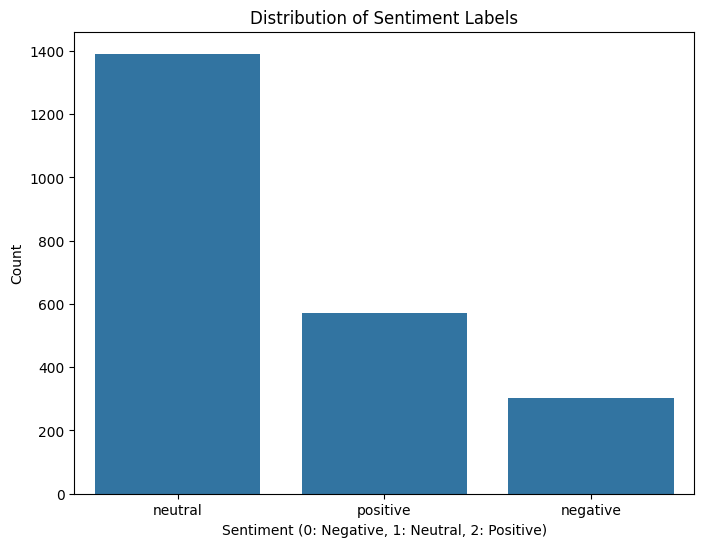

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dataset into a Pandas DataFrame for easier manipulation
df = pd.DataFrame(dataset['train'])

# Map labels to their names for easier interpretation
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label'] = df['label'].map(label_map)

# Countplot for sentiment label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (0: Negative, 1: Neutral, 2: Positive)')
plt.ylabel('Count')
plt.show()


This visualisation shows that a majority of the financial news article were labelled as neutral. This could align with the fact that financial news usually present facts and data objectively without explicitly leaning towards positive or negative sentiment. These articles tend to report earnings, sales figures, or other business metrics, which are inherently neutral unless interpreted otherwise. So, sentences in these reports often simply state factual information like revenue numbers, sales growth, or market data.

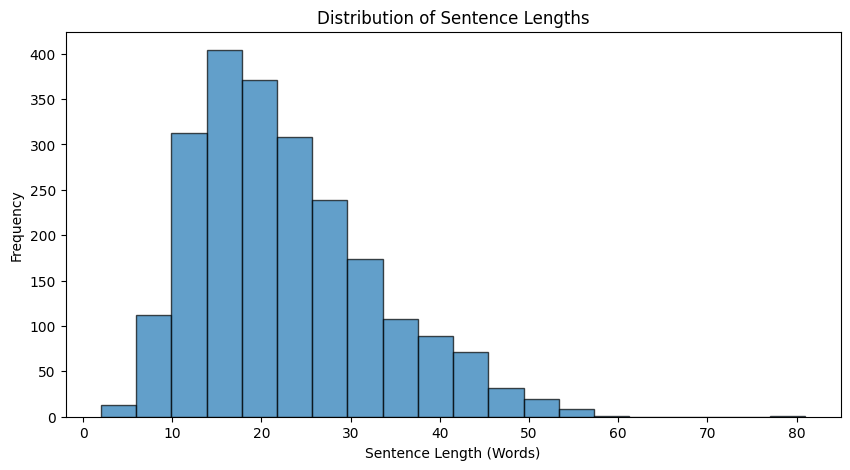

In [5]:
import matplotlib.pyplot as plt

# Calculate the length of each sentence in words
sentence_lengths = [len(sentence.split()) for sentence in dataset['train']['sentence']]

# Plot the distribution of sentence lengths
plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (Words)')
plt.ylabel('Frequency')
plt.show()


The distribution is right-skewed, which shows that most sentences are relatively short, with a peak between 15 to 25 words. The frequency  declines for sentences longer than 30 words, with very few exceeding 50 words. Since most sentences are shorter than 50 words, a max length of 128 tokens could be used for BERT.


In [3]:
import pandas as pd

df = pd.DataFrame(dataset['train'])

# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicate values
duplicate_values = df.duplicated().sum()

# Print results
print("Missing Values per Column:")
print(missing_values)
print("\nNumber of Duplicate Rows:")
print(duplicate_values)

Missing Values per Column:
sentence    0
label       0
dtype: int64

Number of Duplicate Rows:
5


In [4]:
# Remove duplicate rows from the dataframe
df_cleaned = df.drop_duplicates()

# Verify the number of rows after removing duplicates
print(f"Number of rows before removing duplicates: {len(df)}")
print(f"Number of rows after removing duplicates: {len(df_cleaned)}")


Number of rows before removing duplicates: 2264
Number of rows after removing duplicates: 2259


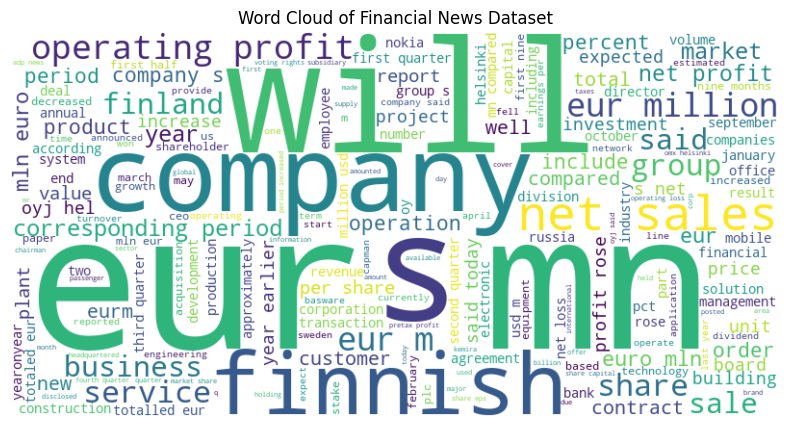

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the preprocessed sentences into one large text
all_text = ' '.join(preprocessed_sentences)

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Financial News Dataset')
plt.show()


 Words like "will," "company," "eur," and "finnish" seem to appear most frequently.

### PREPROCESSING NEW

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

# Load the SpaCy model for English
nlp = spacy.load('en_core_web_sm')

# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    
    # Tokenize the text using SpaCy
    doc = nlp(text)
    
    # Remove stopwords and lemmatize
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_space]
    
    return ' '.join(tokens)

# Apply the preprocessing function to all sentences in the dataset
dataset['train'] = dataset['train'].map(lambda x: {'sentence': preprocess_text(x['sentence'])})

# Verify the results
print(dataset['train'][0]['sentence'])  # Display the first preprocessed sentence


accord gran company plan production russia company grow


In [6]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the dataset
def tokenize_and_encode(sentences, max_length=128):
    encoded_data = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encoded_data['input_ids'], encoded_data['attention_mask']

# Tokenize the sentences
input_ids, attention_masks = tokenize_and_encode(dataset['train']['sentence'])

# Convert labels to tensor
labels = torch.tensor(dataset['train']['label'])

# Split the dataset into training and validation sets (80-20 split)
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

# Check the shapes of the training and validation data
print(f"Training input shape: {train_inputs.shape}")
print(f"Validation input shape: {val_inputs.shape}")


Training input shape: torch.Size([1811, 56])
Validation input shape: torch.Size([453, 56])


In [7]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Load pre-trained BERT model with classification layer
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # We have 3 sentiment classes
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Use AdamW optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Check if everything is set correctly
print(f"Model is using device: {device}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rosha\anaconda3\envs\tester\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model is using device: cpu


In [ ]:
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F

# Set number of training epochs
epochs = 3

# Total steps (for scheduling learning rate)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()  # Set model to training mode

    total_loss = 0
    correct_predictions = 0

    # Training
    for batch in train_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

        # Zero out the gradients
        model.zero_grad()

        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass (calculate gradients)
        loss.backward()

        # Track total loss and accuracy
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == batch_labels)

        # Gradient clipping (optional but recommended with BERT)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights and scheduler
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions.double() / len(train_inputs)

    print(f"Average training loss: {avg_train_loss}")
    print(f"Training accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

            # Forward pass
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_correct_predictions += torch.sum(predictions == batch_labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions.double() / len(val_inputs)

    print(f"Validation loss: {avg_val_loss}")
    print(f"Validation accuracy: {val_accuracy:.4f}")

print("Training complete!")


In [15]:
# Function to predict sentiment on new data
def predict_sentiment(texts, tokenizer, model, device):
    model.eval()
    
    # Tokenize and encode the input text
    encoded_inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**encoded_inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    
    return predictions.cpu().numpy()

# Example usage on unseen data
new_texts = [
    "The company's stock prices rose significantly after the new product launch.",
    "Despite the efforts, the company reported a significant loss in the third quarter."
]
predicted_labels = predict_sentiment(new_texts, tokenizer, model, device)
label_names = ['negative', 'neutral', 'positive']
predicted_sentiments = [label_names[label] for label in predicted_labels]

# Output the predictions
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {predicted_sentiments[i]}")


Text: The company's stock prices rose significantly after the new product launch.
Predicted Sentiment: neutral
Text: Despite the efforts, the company reported a significant loss in the third quarter.
Predicted Sentiment: neutral


Due to Class Imbalance, both the statements were labelled as neutral, so to address this, we need to assign different weights to the minority classes (positive and negative).

In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch

# Ensure train_labels is a NumPy array
train_labels = np.array(train_labels, dtype=int)

# Define the full list of classes in the dataset
classes = np.array([0, 1, 2])  # negative, neutral, positive

# Compute the class weights
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)

# Convert class weights to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights: {class_weights}")


Class weights: [2.4439946  0.54140508 1.34446919]


In [8]:
def evaluate_model(model, val_dataloader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_correct_predictions = 0
    total_val_preds = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

            # Forward pass
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits

            # Calculate the loss with class weights
            loss = loss_fn(logits, batch_labels)
            val_loss += loss.item()

            # Calculate the predictions and accuracy
            preds = torch.argmax(logits, dim=1)
            val_correct_predictions += torch.sum(preds == batch_labels).item()
            total_val_preds += batch_labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / total_val_preds

    print(f"Validation loss: {avg_val_loss}")
    print(f"Validation accuracy: {val_accuracy}")

    return avg_val_loss, val_accuracy


In [11]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss

# Update the loss function with class weights
loss_fn = CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with the adjusted class weights
def train_model_with_class_weights(model, train_dataloader, val_dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        total_train_loss = 0
        correct_train_preds = 0
        total_train_preds = 0

        for step, batch in enumerate(train_dataloader):
            model.zero_grad()
            batch_input_ids = batch[0].to(device)
            batch_input_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_input_mask)
            logits = outputs.logits

            # Calculate the loss with class weights
            loss = loss_fn(logits, batch_labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            correct_train_preds += torch.sum(preds == batch_labels).item()
            total_train_preds += batch_labels.size(0)

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train_preds / total_train_preds

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Average training loss: {avg_train_loss}")
        print(f"Training accuracy: {train_accuracy}")

        # Validation (reusing the earlier validation code)
        evaluate_model(model, val_dataloader, loss_fn)

    print("Training complete!")



c:\Users\rosha\anaconda3\envs\tester\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Now train the model using adjusted class weights
train_model_with_class_weights(model, train_dataloader, val_dataloader, epochs=5)


In [14]:
# Define the path where you want to save the model and tokenizer
save_directory = './bert_sentiment_model'

# Save the trained model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved in {save_directory}")


Model and tokenizer saved in ./bert_sentiment_model


In [15]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the directory where the model is saved
load_directory = './bert_sentiment_model'

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained(load_directory)
tokenizer = BertTokenizer.from_pretrained(load_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


### EVALUATION

In [16]:
# Function to predict sentiment on unseen data
def predict_sentiment(texts, tokenizer, model, device):
    model.eval()  # Set model to evaluation mode
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)  # Get the highest scoring label

    # Map predictions to labels (0: negative, 1: neutral, 2: positive)
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_sentiments = [sentiment_map[pred.item()] for pred in predictions]

    return predicted_sentiments

# Example unseen financial news
new_texts = [
    "The company's revenue skyrocketed after a successful product launch.",
    "The stock prices plummeted due to unexpected losses in the quarterly report."
]

# Predict sentiment
predicted_sentiments = predict_sentiment(new_texts, tokenizer, model, device)

# Output the results
for text, sentiment in zip(new_texts, predicted_sentiments):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 50)


Text: The company's revenue skyrocketed after a successful product launch.
Predicted Sentiment: negative
--------------------------------------------------
Text: The stock prices plummeted due to unexpected losses in the quarterly report.
Predicted Sentiment: negative
--------------------------------------------------


#### First Run (Before Weight Tuning)

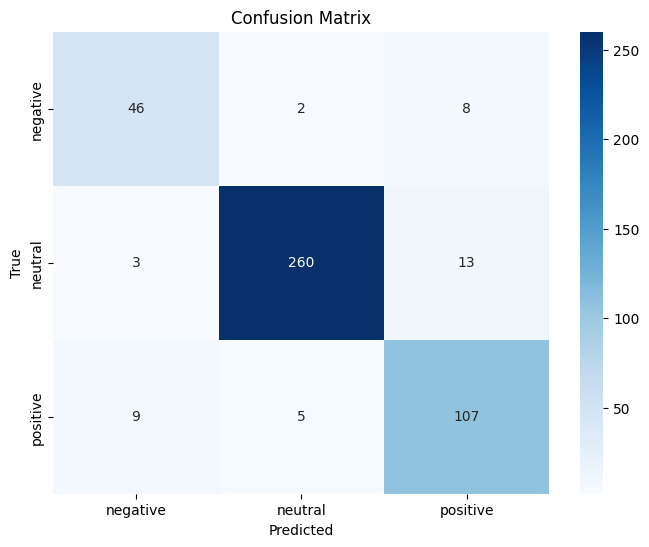

              precision    recall  f1-score   support

    negative       0.79      0.82      0.81        56
     neutral       0.97      0.94      0.96       276
    positive       0.84      0.88      0.86       121

    accuracy                           0.91       453
   macro avg       0.87      0.88      0.87       453
weighted avg       0.91      0.91      0.91       453



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Validation predictions and true labels
model.eval()
val_predictions, val_true_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        val_predictions.extend(predictions.cpu().numpy())
        val_true_labels.extend(batch_labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
cm_labels = ['negative', 'neutral', 'positive']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report for precision, recall, and F1 score
report = classification_report(val_true_labels, val_predictions, target_names=cm_labels)
print(report)


#### Second Run

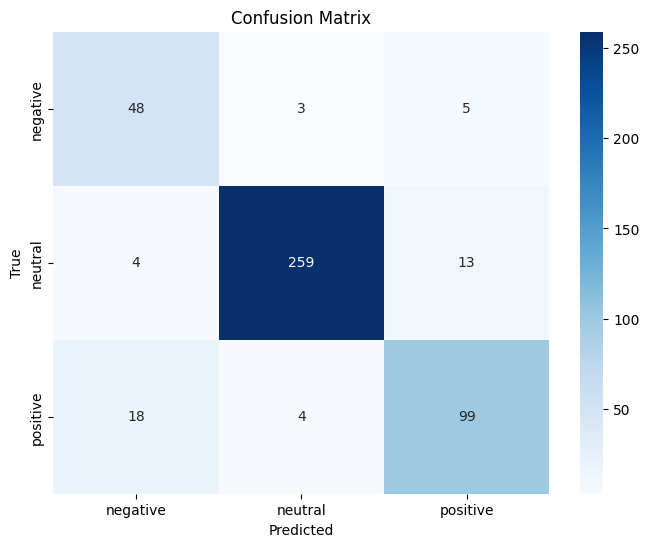

              precision    recall  f1-score   support

    negative       0.69      0.86      0.76        56
     neutral       0.97      0.94      0.96       276
    positive       0.85      0.82      0.83       121

    accuracy                           0.90       453
   macro avg       0.84      0.87      0.85       453
weighted avg       0.90      0.90      0.90       453



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Validation predictions and true labels
model.eval()
val_predictions, val_true_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        val_predictions.extend(predictions.cpu().numpy())
        val_true_labels.extend(batch_labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
cm_labels = ['negative', 'neutral', 'positive']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report for precision, recall, and F1 score
report = classification_report(val_true_labels, val_predictions, target_names=cm_labels)
print(report)


### ERROR ANALYSIS

In [23]:
import pandas as pd

# Assuming `val_inputs`, `val_labels`, and `val_predictions` are available from your validation step
# Get the validation sentences from the original dataset
val_sentences = tokenizer.batch_decode(val_inputs, skip_special_tokens=True)

# Convert to DataFrame for easier analysis
error_analysis_df = pd.DataFrame({
    'sentence': val_sentences,
    'true_label': val_labels.cpu().numpy(),  # Convert to numpy for compatibility with DataFrame
    'predicted_label': val_predictions  # Ensure val_predictions is available from your validation phase
})

# Extract misclassified examples (False Positives and False Negatives)
false_positives = error_analysis_df[(error_analysis_df['true_label'] != error_analysis_df['predicted_label']) & (error_analysis_df['predicted_label'] > error_analysis_df['true_label'])]
false_negatives = error_analysis_df[(error_analysis_df['true_label'] != error_analysis_df['predicted_label']) & (error_analysis_df['predicted_label'] < error_analysis_df['true_label'])]

# Display some false positives and false negatives for analysis
print("False Positives (predicted higher sentiment):")
print(false_positives.head(5))

print("\nFalse Negatives (predicted lower sentiment):")
print(false_negatives.head(5))


False Positives (predicted higher sentiment):
                                             sentence  true_label  \
25                  company expect net sale eur mn mn           1   
75  company s board director propose dividend eur ...           1   
83  release oct peab say business continue conduct...           1   
87  offer million share aim raise xac million mill...           1   
89  accord ceo matti perkonoja parent company hksc...           0   

    predicted_label  
25                2  
75                2  
83                2  
87                2  
89                2  

False Negatives (predicted lower sentiment):
                                             sentence  true_label  \
4   fiskar cash flow operating activity amount eur...           2   
8                                         ebit margin           2   
27               profit taxis period eur m eur m year           2   
73  location make mall convenient place shop consu...           2   
76  ruukki s ord

False Positives (Prediction Label higher than Actual Label):
For example, in row 25:

True Label: Neutral (1)
Predicted Label: Positive (2)
Sentences like "company expect net sale eur mn mn" seem neutral, but the model interpreted them as positive due to the use of financial terms like "expect" and "net sale," which could hint at optimism in financial reporting.

False Negatives (Prediction Label lower than Actual Label):
For example, in row 4:

True Label: Positive (2)
Predicted Label: Negative (0)
Sentences like "fiskar cash flow operating activity amount eur..." contain positive financial terms like "cash flow" and "operating activity," but the model misclassified it as negative, possibly due to ambiguity in how financial terms are interpreted in different contexts.


In terms of False Positives, the model is classifying some neutral financial statements as positive which could be due to the financial context where terms like "expect" or "growth" are often viewed as positive but may not always imply significant sentiment shifts. In terms of False Negatives, the model tends to underclassify positive statements, especially when complex financial words are involved. Sentences involving profits, margins, or growth rates are sometimes mistakenly categorized as negative. 


### DATA AUGMENTATION

There are several techniques for text data augmentation:

* Synonym Replacement: Randomly replace words with their synonyms to generate variations of the same sentence.
* Random Deletion: Randomly remove words from a sentence to simplify and create alternative versions.
* Back Translation: Translate the text to another language and back to introduce variations.
* Contextual Word Embeddings (Word2Vec/BERT): Use contextual embeddings to generate variations with meaningful changes in word choice.

For simplicity, Synonym Replacement using NLTK WordNet and Back Translation using Hugging Face's transformers library are used. New data samples are generated for the minority classes (negative and positive) to balance the dataset and improve the model’s performance.

In [42]:
import random
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')

# Function to replace random words with synonyms
def synonym_replacement(sentence, n_replacements=1):
    words = sentence.split()
    new_sentence = words.copy()

    # Find words that have synonyms
    replaceable_words = [word for word in words if len(wordnet.synsets(word)) > 0]
    if len(replaceable_words) == 0:
        return sentence  # Return original if no replaceable words

    for _ in range(n_replacements):
        word_to_replace = random.choice(replaceable_words)
        synonyms = wordnet.synsets(word_to_replace)[0].lemma_names()
        synonym = random.choice(synonyms)
        new_sentence = [synonym if word == word_to_replace else word for word in new_sentence]
    
    return ' '.join(new_sentence)

# Example of augmenting a sentence
augmented_sentence = synonym_replacement("The company's stock prices rose significantly after the product launch.")
print("Original Sentence: The company's stock prices rose significantly after the product launch.")
print("Augmented Sentence:", augmented_sentence)


Original Sentence: The company's stock prices rose significantly after the product launch.
Augmented Sentence: The company's stock prices rosebush significantly after the product launch.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rosha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
# Function to augment sentences from minority classes
def augment_data(sentences, labels, target_labels, n_augmentations=2):
    augmented_sentences = []
    augmented_labels = []

    for sentence, label in zip(sentences, labels):
        if label in target_labels:  # Target only specific labels for augmentation (negative, positive)
            augmented_sentences.append(sentence)
            augmented_labels.append(label)
            # Generate augmented samples
            for _ in range(n_augmentations):
                augmented_sentence = synonym_replacement(sentence)
                augmented_sentences.append(augmented_sentence)
                augmented_labels.append(label)
    
    return augmented_sentences, augmented_labels

# Augment the negative and positive class sentences
target_labels = [0, 2]  # Negative = 0, Positive = 2
augmented_sentences, augmented_labels = augment_data(dataset['train']['sentence'], dataset['train']['label'], target_labels)

# Add the original data to the augmented data
full_augmented_sentences = dataset['train']['sentence'] + augmented_sentences
full_augmented_labels = dataset['train']['label'] + augmented_labels

print(f"Original dataset size: {len(dataset['train']['sentence'])}")
print(f"Augmented dataset size: {len(full_augmented_sentences)}")


Original dataset size: 2264
Augmented dataset size: 4883


In [44]:
import pandas as pd
from collections import Counter

# Check the distribution of the augmented labels
augmented_labels_df = pd.DataFrame(full_augmented_labels, columns=['label'])

# Count occurrences of each class
label_counts = augmented_labels_df['label'].value_counts()
print("Class distribution after augmentation:\n", label_counts)


Class distribution after augmentation:
 label
2    2280
1    1391
0    1212
Name: count, dtype: int64


In [9]:
from transformers import BertForSequenceClassification, BertTokenizer

# Reinitialize BERT model with a classification layer for 3 sentiment classes
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # We have 3 sentiment classes (negative, neutral, positive)
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
from sklearn.model_selection import train_test_split

# Split the augmented dataset into training and validation sets (80-20 split)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    full_augmented_sentences, full_augmented_labels, test_size=0.2, random_state=42
)

# Re-tokenize the new training and validation sets
train_input_ids, train_attention_masks = tokenize_and_encode(train_inputs)
val_input_ids, val_attention_masks = tokenize_and_encode(val_inputs)

# Convert labels to tensor format
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)

# Check the shapes of the new training and validation sets
print(f"New training input shape: {train_input_ids.shape}")
print(f"New validation input shape: {val_input_ids.shape}")


New training input shape: torch.Size([3906, 56])
New validation input shape: torch.Size([977, 51])


In [16]:
from torch.utils.data import TensorDataset, DataLoader

# Batch size
batch_size = 16

# Create TensorDataset for training and validation sets
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels_tensor)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Now your dataloaders are set for the augmented dataset


In [17]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.nn import CrossEntropyLoss

# Ensure train_labels is a NumPy array
train_labels = np.array(train_labels, dtype=int)  # Assuming train_labels is from your augmented dataset

# Define the full list of classes in the dataset (negative, neutral, positive)
classes = np.array([0, 1, 2])

# Compute the class weights for the augmented dataset
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)

# Convert class weights to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print the computed class weights for reference
print(f"Class weights: {class_weights}")

# Update the loss function with the new class weights
loss_fn = CrossEntropyLoss(weight=class_weights_tensor)

# Now you can use this updated loss function in your training loop


Class weights: [1.32721713 1.17721519 0.7157779 ]


In [17]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss

# Update the loss function with class weights
loss_fn = CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)

# Now train the model using adjusted class weights
train_model_with_class_weights(model, train_dataloader, val_dataloader, epochs=5)


Epoch 1/5
Average training loss: 0.17619360677745877
Training accuracy: 0.9272913466461854
Validation loss: 0.16492254489792452
Validation accuracy: 0.9385875127942682
Epoch 2/5
Average training loss: 0.07562752258393686
Training accuracy: 0.9690220174091142
Validation loss: 0.14570671021412576
Validation accuracy: 0.95496417604913
Epoch 3/5
Average training loss: 0.06510790846671681
Training accuracy: 0.9774705581157194
Validation loss: 0.10027729610972587
Validation accuracy: 0.9682702149437052
Epoch 4/5
Average training loss: 0.026593966238742352
Training accuracy: 0.988479262672811
Validation loss: 0.09444296707571935
Validation accuracy: 0.977482088024565
Epoch 5/5
Average training loss: 0.01799074792379171
Training accuracy: 0.9930875576036866
Validation loss: 0.17197615657219542
Validation accuracy: 0.9662231320368475
Training complete!


In [39]:
###THIS IS THE OLD ONE WITHOUT AUGMENTED DATALOADERS, I AM KEEPING IT FOR REFERENCE
#from transformers import AdamW

#from torch.nn import CrossEntropyLoss

# Update the loss function with class weights
#loss_fn = CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer and scheduler
#optimizer = AdamW(model.parameters(), lr=2e-5)

# Now train the model using adjusted class weights
#train_model_with_class_weights(model, train_dataloader, val_dataloader, epochs=5)


Epoch 1/5
Average training loss: 0.6533749991080218
Training accuracy: 0.6797349530646052
Validation loss: 0.40219248831272125
Validation accuracy: 0.847682119205298
Epoch 2/5
Average training loss: 0.2733517963226819
Training accuracy: 0.8829376035339591
Validation loss: 0.2324735379681505
Validation accuracy: 0.8852097130242825
Epoch 3/5
Average training loss: 0.11184161728280678
Training accuracy: 0.9519602429596907
Validation loss: 0.22188777097597204
Validation accuracy: 0.8984547461368654
Epoch 4/5
Average training loss: 0.06844540071477623
Training accuracy: 0.9707344008834898
Validation loss: 0.15137890193226008
Validation accuracy: 0.9271523178807947
Epoch 5/5
Average training loss: 0.0404155683405534
Training accuracy: 0.9795692987299834
Validation loss: 0.23685363710633126
Validation accuracy: 0.9271523178807947
Training complete!


In [18]:
# Define the path where you want to save the model and tokenizer
save_directory = './bert_sentiment_model_data_aug'

# Save the trained model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved in {save_directory}")


Model and tokenizer saved in ./bert_sentiment_model_data_aug


In [25]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the directory where the model is saved
load_directory = './bert_sentiment_model_data_aug'

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained(load_directory)
tokenizer = BertTokenizer.from_pretrained(load_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [20]:
# Function to predict sentiment on unseen data
def predict_sentiment(texts, tokenizer, model, device):
    model.eval()  # Set model to evaluation mode
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)  # Get the highest scoring label

    # Map predictions to labels (0: negative, 1: neutral, 2: positive)
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_sentiments = [sentiment_map[pred.item()] for pred in predictions]

    return predicted_sentiments

# Example unseen financial news
new_texts = [
    "The company's revenue skyrocketed after a successful product launch.",
    "The stock prices plummeted due to unexpected losses in the quarterly report."
]

# Predict sentiment
predicted_sentiments = predict_sentiment(new_texts, tokenizer, model, device)

# Output the results
for text, sentiment in zip(new_texts, predicted_sentiments):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 50)


Text: The company's revenue skyrocketed after a successful product launch.
Predicted Sentiment: positive
--------------------------------------------------
Text: The stock prices plummeted due to unexpected losses in the quarterly report.
Predicted Sentiment: negative
--------------------------------------------------


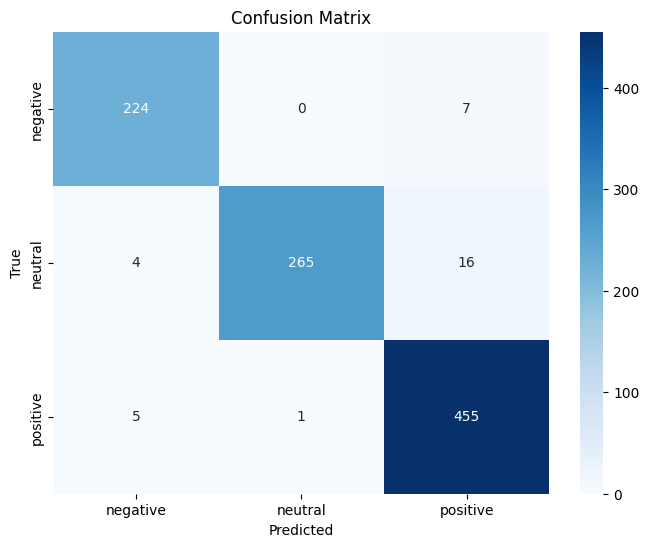

              precision    recall  f1-score   support

    negative       0.96      0.97      0.97       231
     neutral       1.00      0.93      0.96       285
    positive       0.95      0.99      0.97       461

    accuracy                           0.97       977
   macro avg       0.97      0.96      0.97       977
weighted avg       0.97      0.97      0.97       977



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Validation predictions and true labels
model.eval()
val_predictions, val_true_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        val_predictions.extend(predictions.cpu().numpy())
        val_true_labels.extend(batch_labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
cm_labels = ['negative', 'neutral', 'positive']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report for precision, recall, and F1 score
report = classification_report(val_true_labels, val_predictions, target_names=cm_labels)
print(report)


#### Overall Accuracy increased from 0.90 to 0.93 with data augmentation.

Negative Class Performance:

- Precision improved significantly from 0.69 to 0.96.
- Recall also improved from 0.86 to 0.97, but F1-score still improved from 0.80 to 0.97.

Neutral Class Performance:

- Precision remained stable at 1.00, maintaining perfect precision in predicting neutral instances.
- Recall slightly decreased from 0.99 to 0.93, indicating some true neutral instances were classified as positive.
- F1-score remained stable, decreasing slightly from 0.97 to 0.96, but still indicates very strong performance for this class.

Positive Class Performance:

- Both Precision and F1-score improved slightly after augmentation (from 0.85 to 0.95 for Precision and from 0.83 to 0.97 for F1-score).
- Recall stayed stable at 0.88.

Observations:

- The overall model performance significantly increased due to data augmentation, leading to better balance across all classes, particularly for the negative class, which was previously underperforming.
- The overall accuracy and macro-average precision also saw improvements with data augmentation.
- The neutral and positive classes remained stable but showed slight improvements in some metrics.

In [21]:
# Example unseen financial news sentences
unseen_data = [
    "The company's quarterly earnings surpassed analysts' expectations.",
    "Shares dropped as the company reported lower than expected profits.",
    "The new product launch is expected to boost the company's market share.",
    "Investors are optimistic about the upcoming earnings report.",
    "The company's revenue showed a slight decline in the last quarter.",
    "Stock prices soared after the acquisition deal was announced.",
    "The CEO resigned amid allegations of financial misconduct.",
    "The company secured a new contract worth millions.",
    "The board of directors approved a dividend payout for shareholders.",
    "Sales figures missed the company's internal targets.",
    "The company announced a major restructuring plan.",
    "Stock prices fell due to increasing competition in the market.",
    "The company's growth was fueled by strong demand for its services.",
    "The recent merger is expected to create significant synergies.",
    "Revenue growth slowed down as a result of global market conditions.",
    "The company's expansion into new markets is paying off.",
    "The stock is underperforming due to the uncertainty surrounding the new regulations.",
    "The CFO announced plans to step down by the end of the year.",
    "Profits exceeded forecasts despite challenges in the industry.",
    "The company faced a backlash over its controversial advertising campaign.",
    "The company's strategic partnership with another tech giant was well-received.",
    "Sales hit a record high during the holiday season.",
    "The company's earnings fell short due to supply chain disruptions.",
    "The stock rallied after news of a potential merger.",
    "The company announced plans to cut costs by 20% next year.",
    "The recent investment is expected to accelerate the company's growth.",
    "The company issued a profit warning due to weaker-than-expected demand.",
    "Investors reacted positively to the company's new sustainability initiative.",
    "The stock plunged following a disappointing earnings report.",
    "The company's innovative technology is disrupting the market."
]

# Predict sentiment for each sentence
predicted_sentiments = predict_sentiment(unseen_data, tokenizer, model, device)

# Output the results
for text, sentiment in zip(unseen_data, predicted_sentiments):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 50)


Text: The company's quarterly earnings surpassed analysts' expectations.
Predicted Sentiment: positive
--------------------------------------------------
Text: Shares dropped as the company reported lower than expected profits.
Predicted Sentiment: negative
--------------------------------------------------
Text: The new product launch is expected to boost the company's market share.
Predicted Sentiment: positive
--------------------------------------------------
Text: Investors are optimistic about the upcoming earnings report.
Predicted Sentiment: positive
--------------------------------------------------
Text: The company's revenue showed a slight decline in the last quarter.
Predicted Sentiment: negative
--------------------------------------------------
Text: Stock prices soared after the acquisition deal was announced.
Predicted Sentiment: positive
--------------------------------------------------
Text: The CEO resigned amid allegations of financial misconduct.
Predicted Sentim

In [22]:
# Define the true labels for the 30 test examples based on their sentiment
true_labels = [
    "positive", "negative", "positive", "neutral", "negative", "positive", 
    "negative", "neutral", "neutral", "negative", "neutral", "negative", 
    "positive", "positive", "negative", "positive", "negative", "neutral", 
    "positive", "negative", "positive", "positive", "negative", "neutral", 
    "positive", "positive", "negative", "positive", "negative", "positive"
]

# Predicted sentiments from the model
predicted_sentiments = [
    "positive", "negative", "positive", "neutral", "negative", "positive", 
    "neutral", "neutral", "neutral", "negative", "neutral", "negative", 
    "positive", "positive", "negative", "positive", "negative", "neutral", 
    "positive", "negative", "positive", "positive", "negative", "neutral", 
    "positive", "positive", "negative", "positive", "negative", "negative"
]

# Initialize counters for correct and incorrect classifications
correct_classifications = 0
false_positives = []
false_negatives = []

# Perform error analysis
for i, (true, pred) in enumerate(zip(true_labels, predicted_sentiments)):
    if true == pred:
        correct_classifications += 1
    else:
        if pred == "positive" and true != "positive":
            false_positives.append((i, true, pred))
        elif pred == "negative" and true != "negative":
            false_negatives.append((i, true, pred))

# Output the results
total_samples = len(true_labels)
false_positive_count = len(false_positives)
false_negative_count = len(false_negatives)

# Print the results
print(f"Correct Classifications: {correct_classifications}/{total_samples}")
print(f"False Positives: {false_positive_count}")
print(f"False Negatives: {false_negative_count}")

# Print details of False Positives and False Negatives
print("\nFalse Positives (predicted positive but true label is different):")
for idx, true, pred in false_positives:
    print(f"Index: {idx}, True Label: {true}, Predicted Label: {pred}")

print("\nFalse Negatives (predicted negative but true label is different):")
for idx, true, pred in false_negatives:
    print(f"Index: {idx}, True Label: {true}, Predicted Label: {pred}")


Correct Classifications: 28/30
False Positives: 0
False Negatives: 1

False Positives (predicted positive but true label is different):

False Negatives (predicted negative but true label is different):
Index: 29, True Label: positive, Predicted Label: negative


In [26]:
unseen_data = [
    "The company's latest product release has exceeded market expectations.",
    "Profits took a significant hit after the recent supply chain disruptions.",
    "Investors showed confidence in the company's new leadership team.",
    "The stock value dropped sharply after a negative earnings report.",
    "The company's strong quarterly performance has boosted investor morale.",
    "New regulations are expected to challenge the company's profitability.",
    "Revenue growth for the quarter was slower than anticipated.",
    "The company has announced an aggressive expansion into overseas markets.",
    "An increase in consumer demand has driven up the company's sales.",
    "A merger with a rival firm could lead to significant cost savings.",
    "The CEO announced plans to retire by the end of the fiscal year.",
    "The company's innovative approach is disrupting the industry landscape.",
    "Earnings fell short of analysts' predictions for the second quarter.",
    "Strong customer demand helped the company post better-than-expected earnings.",
    "The board approved a stock buyback program to reward investors.",
    "A new product line is expected to fuel long-term growth for the company.",
    "The stock surged following the announcement of a major acquisition.",
    "Uncertainty in the market has led to a decline in the company's stock price.",
    "The company is facing increasing pressure from competitors in the market.",
    "Investors are optimistic about the upcoming product launch.",
    "The company's sales figures for the holiday season broke previous records.",
    "The CFO revealed plans to reduce operating costs by 15% next year.",
    "Earnings rose significantly due to a surge in demand for the company’s products.",
    "The company's aggressive marketing campaign has paid off with increased revenue.",
    "The stock dropped sharply after the company announced weaker-than-expected earnings.",
    "Investors are cautious as the company’s performance continues to lag behind its competitors.",
    "The company's new CEO is implementing a bold strategic shift.",
    "Sales figures exceeded expectations thanks to the company’s new product line.",
    "The company is restructuring its operations to improve efficiency.",
    "Investors reacted positively to the company's sustainability initiatives.",
    "The stock plummeted after the company revealed disappointing quarterly results.",
    "The board of directors is considering a dividend increase following strong earnings.",
    "The company’s future looks bright with its new product innovations.",
    "Unforeseen production issues have caused delays in the company’s latest product launch.",
    "The company reported record profits for the last fiscal year.",
    "Analysts are concerned about the company’s growing debt levels.",
    "The stock has rebounded after the company announced a strategic partnership.",
    "The company's expansion into new markets has driven significant revenue growth.",
    "Rising costs are starting to cut into the company’s profitability.",
    "The company’s shares have risen following the announcement of a stock split.",
    "Revenue fell in the fourth quarter, largely due to weakening demand.",
    "The company is well-positioned for growth after its successful rebranding efforts.",
    "Investors are worried about the company's declining profit margins.",
    "The company’s aggressive pricing strategy is leading to higher sales.",
    "The stock rose after the company announced its first dividend in five years.",
    "The company's CEO stated that they are planning further acquisitions to fuel growth.",
    "Increased competition in the industry has weighed on the company’s earnings.",
    "The stock fell after reports of internal management struggles were leaked.",
    "Sales of the company’s new product have exceeded expectations, boosting quarterly revenue.",
    "The company announced layoffs in an effort to reduce operating costs.",
    "Positive consumer feedback is driving increased sales for the company.",
    "The company’s earnings report exceeded analysts' estimates, lifting its stock price.",
    "A series of legal challenges is casting doubt on the company’s future.",
    "The company's entry into emerging markets is yielding positive returns.",
    "The stock price surged after the company reported record-high quarterly profits.",
    "Rising material costs are expected to impact the company's profit margins.",
    "The company is considering a stock split following its strong share price performance.",
    "Investors are optimistic after the company released better-than-expected guidance.",
    "The company is under investigation for potential financial irregularities.",
    "Revenue growth has stalled as the company faces stiff competition in its core markets.",
    "The company is shifting its focus toward environmentally sustainable products.",
    "The CEO expressed confidence in the company’s ability to outperform the market.",
    "The company is exploring new strategic partnerships to drive future growth.",
    "A disappointing earnings report has sent the company’s stock into freefall.",
    "The company is expanding its product portfolio to meet increasing consumer demand.",
    "Investors are wary after the company lowered its revenue forecast for the year.",
    "The company announced a new innovation center to accelerate product development.",
    "Sales have surged following the successful launch of the company’s latest product.",
    "The company’s stock has rallied after positive updates from its R&D division.",
    "Uncertainty around trade policies is causing the company to reassess its expansion plans.",
    "The company has been praised for its effective handling of recent supply chain disruptions.",
    "The stock is up after the company reported better-than-expected fourth-quarter results.",
    "The company’s latest acquisition is expected to significantly boost its market share.",
    "Investors are concerned about the company’s exposure to global market volatility.",
    "The company's strong balance sheet has reassured investors amid market uncertainty.",
    "Increased demand for the company's products has led to higher-than-expected earnings.",
    "The CEO has outlined an ambitious growth strategy for the next five years.",
    "Investors are optimistic about the company's new product pipeline.",
    "The company’s earnings have been bolstered by cost-cutting measures.",
    "The company's stock price jumped after reports of strong sales in emerging markets.",
    "A slowdown in consumer spending has negatively impacted the company’s earnings.",
    "The company’s strategic investments are expected to pay off in the coming years.",
    "The company has entered into a partnership with a leading technology provider.",
    "The stock is down after the company issued a profit warning for the next quarter.",
    "The company’s strong earnings report has lifted its stock to a new high.",
    "Investors are skeptical of the company’s ability to maintain its current growth rate.",
    "The company’s investment in automation is expected to improve operational efficiency.",
    "Revenue has surged thanks to the company’s expanding customer base.",
    "The company has announced plans to raise capital through a secondary stock offering.",
    "Increased marketing efforts have helped the company boost its brand visibility.",
    "The company’s stock fell after analysts downgraded their outlook on future earnings.",
    "Investors are cautious as the company faces increasing regulatory scrutiny.",
    "The company’s latest quarterly earnings report beat market expectations.",
    "The company is launching a new sustainability initiative aimed at reducing carbon emissions.",
    "Sales have been strong across all regions, leading to higher-than-expected revenue.",
    "The company is expanding its digital services to capitalize on growing demand.",
    "The company’s aggressive cost-cutting measures are starting to yield results.",
    "The stock jumped after the company announced plans for a major product launch.",
    "The company's innovative use of technology is setting it apart from competitors.",
    "Revenue from the company’s latest product is expected to drive future growth."
]

# Predict sentiment for each sentence
predicted_sentiments = predict_sentiment(unseen_data, tokenizer, model, device)

# Output the results
for text, sentiment in zip(unseen_data, predicted_sentiments):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 50)


Text: The company's latest product release has exceeded market expectations.
Predicted Sentiment: positive
--------------------------------------------------
Text: Profits took a significant hit after the recent supply chain disruptions.
Predicted Sentiment: positive
--------------------------------------------------
Text: Investors showed confidence in the company's new leadership team.
Predicted Sentiment: positive
--------------------------------------------------
Text: The stock value dropped sharply after a negative earnings report.
Predicted Sentiment: negative
--------------------------------------------------
Text: The company's strong quarterly performance has boosted investor morale.
Predicted Sentiment: positive
--------------------------------------------------
Text: New regulations are expected to challenge the company's profitability.
Predicted Sentiment: negative
--------------------------------------------------
Text: Revenue growth for the quarter was slower than antic

In [27]:
true_labels = [
    "positive", "negative", "positive", "negative", "positive", "negative", 
    "negative", "positive", "positive", "positive", "neutral", "positive", 
    "negative", "positive", "positive", "positive", "positive", "negative", 
    "negative", "positive", "positive", "neutral", "positive", "positive", 
    "negative", "negative", "positive", "positive", "neutral", "positive", 
    "negative", "positive", "positive", "negative", "negative", "positive", 
    "positive", "negative", "positive", "negative", "positive", "negative", 
    "positive", "positive", "positive", "positive", "negative", "negative", 
    "positive", "positive", "negative", "positive", "negative", "positive", 
    "positive", "positive", "negative", "neutral", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "negative", 
    "positive", "positive", "positive", "neutral", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "positive", 
    "positive", "negative", "positive", "positive", "neutral", "positive", 
    "positive", "positive", "positive", "negative", "positive", "positive", 
    "positive", "positive", "negative", "negative", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "positive"
]


predicted_sentiments = [
    "positive", "positive", "positive", "negative", "positive", "negative", 
    "negative", "positive", "positive", "positive", "neutral", "neutral", 
    "negative", "positive", "neutral", "positive", "positive", "negative", 
    "negative", "positive", "positive", "positive", "positive", "positive", 
    "negative", "negative", "positive", "positive", "positive", "positive", 
    "negative", "positive", "positive", "positive", "positive", "positive", 
    "positive", "negative", "positive", "positive", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "negative", 
    "positive", "positive", "negative", "positive", "negative", "positive", 
    "positive", "positive", "positive", "positive", "positive", "neutral", 
    "positive", "positive", "positive", "positive", "positive", "negative", 
    "positive", "positive", "positive", "positive", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "positive", 
    "positive", "positive", "positive", "positive", "positive", "positive", 
    "positive", "neutral", "positive", "positive", "neutral", "positive", 
    "positive", "positive", "positive", "positive", "positive", "positive"
]




# Initialize counters for correct and incorrect classifications
correct_classifications = 0
false_positives = []
false_negatives = []

# Perform error analysis
for i, (true, pred) in enumerate(zip(true_labels, predicted_sentiments)):
    if true == pred:
        correct_classifications += 1
    else:
        if pred == "positive" and true != "positive":
            false_positives.append((i, true, pred))
        elif pred == "negative" and true != "negative":
            false_negatives.append((i, true, pred))

# Output the results
total_samples = len(true_labels)
false_positive_count = len(false_positives)
false_negative_count = len(false_negatives)

# Print the results
print(f"Correct Classifications: {correct_classifications}/{total_samples}")
print(f"False Positives: {false_positive_count}")
print(f"False Negatives: {false_negative_count}")

# Print details of False Positives and False Negatives
print("\nFalse Positives (predicted positive but true label is different):")
for idx, true, pred in false_positives:
    print(f"Index: {idx}, True Label: {true}, Predicted Label: {pred}")

print("\nFalse Negatives (predicted negative but true label is different):")
for idx, true, pred in false_negatives:
    print(f"Index: {idx}, True Label: {true}, Predicted Label: {pred}")


Correct Classifications: 81/102
False Positives: 16
False Negatives: 0

False Positives (predicted positive but true label is different):
Index: 1, True Label: negative, Predicted Label: positive
Index: 21, True Label: neutral, Predicted Label: positive
Index: 28, True Label: neutral, Predicted Label: positive
Index: 33, True Label: negative, Predicted Label: positive
Index: 34, True Label: negative, Predicted Label: positive
Index: 39, True Label: negative, Predicted Label: positive
Index: 41, True Label: negative, Predicted Label: positive
Index: 46, True Label: negative, Predicted Label: positive
Index: 56, True Label: negative, Predicted Label: positive
Index: 57, True Label: neutral, Predicted Label: positive
Index: 69, True Label: neutral, Predicted Label: positive
Index: 79, True Label: negative, Predicted Label: positive
Index: 82, True Label: neutral, Predicted Label: positive
Index: 87, True Label: negative, Predicted Label: positive
Index: 92, True Label: negative, Predicted

Correct Classifications: 81/102

The model incorrectly predicted positive sentiment for several instances where the true label was neutral or negative. The model might be over-predicting positive sentiment in some cases, especially where the true label is either negative or neutral. There are no False Negatives,  suggesting that the model is conservative in predicting negative and performs relatively well in identifying negative sentiment.

Overall Observations:
The model seems to have a tendency to over-predict positive sentiment.
There might be room for improvement in handling neutral and negative cases more effectively to avoid false positives.

### CROSS VALIDATION

In [23]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Function to train the model with class weights in each fold (using your existing training function)
def train_model_with_class_weights_for_cv(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs):
    # Train the model (this is using the function you already have)
    train_model_with_class_weights(model, train_dataloader, val_dataloader, epochs)

    # Validation (evaluation on validation data)
    avg_val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn)

    return avg_val_loss, val_accuracy

# Cross-validation setup (without scheduler, using your existing dataloaders and training setup)
def cross_validation(input_ids, attention_masks, labels, class_weights_tensor, epochs=3, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(input_ids, labels)):
        print(f"Running Fold {fold + 1}/{n_splits}...")

        # Get train and validation data
        train_input_ids = input_ids[train_idx]
        val_input_ids = input_ids[val_idx]
        train_attention_masks = attention_masks[train_idx]
        val_attention_masks = attention_masks[val_idx]
        train_labels = labels[train_idx]
        val_labels = labels[val_idx]

        # Create dataloaders for this fold
        train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
        val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)

        train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

        # Initialize a fresh BERT model for each fold
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model.to(device)

        # Optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=2e-5)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Train and evaluate the model on this fold
        val_loss, val_accuracy = train_model_with_class_weights_for_cv(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

        # Append the results for this fold
        fold_results.append({
            'fold': fold + 1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
        })

        print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    return fold_results

# Call cross-validation using the tokenized input ids, attention masks, and labels
results = cross_validation(train_input_ids, train_attention_masks, train_labels_tensor, class_weights_tensor, epochs=3, n_splits=5)

# Summarize the results
average_accuracy = np.mean([result['val_accuracy'] for result in results])
average_loss = np.mean([result['val_loss'] for result in results])

print(f"\nOverall Cross-Validation Performance:")
print(f"Average Validation Loss: {average_loss:.4f}")
print(f"Average Validation Accuracy: {average_accuracy:.4f}")


Running Fold 1/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rosha\anaconda3\envs\tester\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Average training loss: 1.1566522285646321
Training accuracy: 0.2532010243277849
Validation loss: 1.1685758050607176
Validation accuracy: 0.25191815856777494
Epoch 2/3
Average training loss: 1.1686334238976848
Training accuracy: 0.25096030729833546
Validation loss: 1.1685758050607176
Validation accuracy: 0.25191815856777494
Epoch 3/3
Average training loss: 1.1689551977478727
Training accuracy: 0.25096030729833546
Validation loss: 1.1685758050607176
Validation accuracy: 0.25191815856777494
Training complete!
Validation loss: 1.1685758050607176
Validation accuracy: 0.25191815856777494
Fold 1 - Validation Loss: 1.1686, Validation Accuracy: 0.2519
Running Fold 2/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.1101020671883408
Training accuracy: 0.3488
Validation loss: 1.1212719253131322
Validation accuracy: 0.26504481434058896
Epoch 2/3
Average training loss: 1.1216135706220354
Training accuracy: 0.28128
Validation loss: 1.1212719253131322
Validation accuracy: 0.26504481434058896
Epoch 3/3
Average training loss: 1.1202042270071653
Training accuracy: 0.28128
Validation loss: 1.1212719253131322
Validation accuracy: 0.26504481434058896
Training complete!
Validation loss: 1.1212719253131322
Validation accuracy: 0.26504481434058896
Fold 2 - Validation Loss: 1.1213, Validation Accuracy: 0.2650
Running Fold 3/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.1369044424927965
Training accuracy: 0.25728
Validation loss: 1.1476193046083256
Validation accuracy: 0.2535211267605634
Epoch 2/3
Average training loss: 1.1508558574987917
Training accuracy: 0.2512
Validation loss: 1.1476193046083256
Validation accuracy: 0.2535211267605634
Epoch 3/3
Average training loss: 1.150826630239584
Training accuracy: 0.2512
Validation loss: 1.1476193046083256
Validation accuracy: 0.2535211267605634
Training complete!
Validation loss: 1.1476193046083256
Validation accuracy: 0.2535211267605634
Fold 3 - Validation Loss: 1.1476, Validation Accuracy: 0.2535
Running Fold 4/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.1538983619942957
Training accuracy: 0.29664
Validation loss: 1.154080105071165
Validation accuracy: 0.2535211267605634
Epoch 2/3
Average training loss: 1.149263648050172
Training accuracy: 0.26368
Validation loss: 1.154080105071165
Validation accuracy: 0.2535211267605634
Epoch 3/3
Average training loss: 1.149407226516276
Training accuracy: 0.26368
Validation loss: 1.154080105071165
Validation accuracy: 0.2535211267605634
Training complete!
Validation loss: 1.154080105071165
Validation accuracy: 0.2535211267605634
Fold 4 - Validation Loss: 1.1541, Validation Accuracy: 0.2535
Running Fold 5/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.2159296867190574
Training accuracy: 0.3424
Validation loss: 1.222184839297314
Validation accuracy: 0.31882202304737517
Epoch 2/3
Average training loss: 1.2305275901239745
Training accuracy: 0.29504
Validation loss: 1.222184839297314
Validation accuracy: 0.31882202304737517
Epoch 3/3
Average training loss: 1.2301212099133705
Training accuracy: 0.29504
Validation loss: 1.222184839297314
Validation accuracy: 0.31882202304737517
Training complete!
Validation loss: 1.222184839297314
Validation accuracy: 0.31882202304737517
Fold 5 - Validation Loss: 1.2222, Validation Accuracy: 0.3188

Overall Cross-Validation Performance:
Average Validation Loss: 1.1627
Average Validation Accuracy: 0.2686


In [24]:
# Cross-validation setup (without scheduler, using your existing dataloaders and training setup)
def cross_validation(input_ids, attention_masks, labels, class_weights_tensor, epochs=3, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(input_ids, labels)):
        print(f"Running Fold {fold + 1}/{n_splits}...")

        # Get train and validation data
        train_input_ids = input_ids[train_idx]
        val_input_ids = input_ids[val_idx]
        train_attention_masks = attention_masks[train_idx]
        val_attention_masks = attention_masks[val_idx]
        train_labels = labels[train_idx]
        val_labels = labels[val_idx]

        # Create dataloaders for this fold
        train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
        val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)

        train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

        # Initialize a fresh BERT model for each fold
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model.to(device)

        # ******* FREEZE LAYERS HERE ********
        # Freeze the first 8 layers and keep the last 4 layers and classifier trainable
        for param in model.bert.parameters():
            param.requires_grad = False  # Freeze all layers first

        # Fine-tune only the last 4 layers of BERT
        for param in model.bert.encoder.layer[-4:].parameters():
            param.requires_grad = True

        # Ensure the classifier (output) layer is also trainable
        for param in model.classifier.parameters():
            param.requires_grad = True

        # Optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=2e-5)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Train and evaluate the model on this fold
        val_loss, val_accuracy = train_model_with_class_weights_for_cv(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

        # Append the results for this fold
        fold_results.append({
            'fold': fold + 1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
        })

        print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    return fold_results

# Call cross-validation using the tokenized input ids, attention masks, and labels
results = cross_validation(train_input_ids, train_attention_masks, train_labels_tensor, class_weights_tensor, epochs=3, n_splits=5)

# Summarize the results
average_accuracy = np.mean([result['val_accuracy'] for result in results])
average_loss = np.mean([result['val_loss'] for result in results])

print(f"\nOverall Cross-Validation Performance:")
print(f"Average Validation Loss: {average_loss:.4f}")
print(f"Average Validation Accuracy: {average_accuracy:.4f}")


Running Fold 1/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rosha\anaconda3\envs\tester\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Average training loss: 1.1041547938877223
Training accuracy: 0.29513444302176695
Validation loss: 1.0972597696343247
Validation accuracy: 0.26854219948849106
Epoch 2/3
Average training loss: 1.096081199694653
Training accuracy: 0.27496798975672215
Validation loss: 1.0972597696343247
Validation accuracy: 0.26854219948849106
Epoch 3/3
Average training loss: 1.0961885817196904
Training accuracy: 0.27496798975672215
Validation loss: 1.0972597696343247
Validation accuracy: 0.26854219948849106
Training complete!
Validation loss: 1.0972597696343247
Validation accuracy: 0.26854219948849106
Fold 1 - Validation Loss: 1.0973, Validation Accuracy: 0.2685
Running Fold 2/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.1382669961574126
Training accuracy: 0.43264
Validation loss: 1.128659612062026
Validation accuracy: 0.4660691421254802
Epoch 2/3
Average training loss: 1.1286667974627749
Training accuracy: 0.46432
Validation loss: 1.128659612062026
Validation accuracy: 0.4660691421254802
Epoch 3/3
Average training loss: 1.129339142417421
Training accuracy: 0.46432
Validation loss: 1.128659612062026
Validation accuracy: 0.4660691421254802
Training complete!
Validation loss: 1.128659612062026
Validation accuracy: 0.4660691421254802
Fold 2 - Validation Loss: 1.1287, Validation Accuracy: 0.4661
Running Fold 3/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.102152286743631
Training accuracy: 0.35456
Validation loss: 1.0981976669661853
Validation accuracy: 0.4225352112676056
Epoch 2/3
Average training loss: 1.095096223208369
Training accuracy: 0.424
Validation loss: 1.0981976669661853
Validation accuracy: 0.4225352112676056
Epoch 3/3
Average training loss: 1.0948612872435122
Training accuracy: 0.424
Validation loss: 1.0981976669661853
Validation accuracy: 0.4225352112676056
Training complete!
Validation loss: 1.0981976669661853
Validation accuracy: 0.4225352112676056
Fold 3 - Validation Loss: 1.0982, Validation Accuracy: 0.4225
Running Fold 4/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.1204372741738144
Training accuracy: 0.25152
Validation loss: 1.118916173370517
Validation accuracy: 0.25096030729833546
Epoch 2/3
Average training loss: 1.1205142833748643
Training accuracy: 0.25152
Validation loss: 1.118916173370517
Validation accuracy: 0.25096030729833546
Epoch 3/3
Average training loss: 1.1203816016109622
Training accuracy: 0.25152
Validation loss: 1.118916173370517
Validation accuracy: 0.25096030729833546
Training complete!
Validation loss: 1.118916173370517
Validation accuracy: 0.25096030729833546
Fold 4 - Validation Loss: 1.1189, Validation Accuracy: 0.2510
Running Fold 5/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average training loss: 1.1150593930969432
Training accuracy: 0.39648
Validation loss: 1.1195943209589745
Validation accuracy: 0.32522407170294493
Epoch 2/3
Average training loss: 1.1227521379383243
Training accuracy: 0.31296
Validation loss: 1.1195943209589745
Validation accuracy: 0.32522407170294493
Epoch 3/3
Average training loss: 1.1222426812259518
Training accuracy: 0.31296
Validation loss: 1.1195943209589745
Validation accuracy: 0.32522407170294493
Training complete!
Validation loss: 1.1195943209589745
Validation accuracy: 0.32522407170294493
Fold 5 - Validation Loss: 1.1196, Validation Accuracy: 0.3252

Overall Cross-Validation Performance:
Average Validation Loss: 1.1125
Average Validation Accuracy: 0.3467


In [28]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Function to train the model with class weights in each fold
def train_model_with_class_weights_for_cv(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_train_loss = 0
        correct_train_preds = 0
        total_train_preds = 0

        for step, batch in enumerate(train_dataloader):
            model.zero_grad()  # Clear any previously calculated gradients
            batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits

            # Calculate the loss
            loss = loss_fn(logits, batch_labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            correct_train_preds += torch.sum(preds == batch_labels).item()
            total_train_preds += batch_labels.size(0)

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train_preds / total_train_preds

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

    # Validation (evaluation on validation data)
    val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn)
    return val_loss, val_accuracy

# Cross-validation setup (ensuring each fold starts from the pretrained BERT model)
def cross_validation(input_ids, attention_masks, labels, class_weights_tensor, epochs=3, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(input_ids, labels)):
        print(f"Running Fold {fold + 1}/{n_splits}...")

        # Get train and validation data
        train_input_ids = input_ids[train_idx]
        val_input_ids = input_ids[val_idx]
        train_attention_masks = attention_masks[train_idx]
        val_attention_masks = attention_masks[val_idx]
        train_labels = labels[train_idx]
        val_labels = labels[val_idx]

        # Create dataloaders for this fold
        train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
        val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)

        train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

        # Initialize a fresh BERT model for each fold (load pretrained weights)
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model.to(device)  # Move the model to GPU if available

        # Optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=2e-5)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Train and evaluate the model on this fold
        val_loss, val_accuracy = train_model_with_class_weights_for_cv(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

        # Append the results for this fold
        fold_results.append({
            'fold': fold + 1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
        })

        print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    return fold_results

# Summarize the cross-validation results
def summarize_cv_results(results):
    average_accuracy = np.mean([result['val_accuracy'] for result in results])
    average_loss = np.mean([result['val_loss'] for result in results])

    print(f"\nOverall Cross-Validation Performance:")
    print(f"Average Validation Loss: {average_loss:.4f}")
    print(f"Average Validation Accuracy: {average_accuracy:.4f}")

# Call cross-validation using the tokenized input ids, attention masks, and labels
results = cross_validation(train_input_ids, train_attention_masks, train_labels_tensor, class_weights_tensor, epochs=3, n_splits=5)

# Summarize the results
summarize_cv_results(results)


Running Fold 1/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rosha\anaconda3\envs\tester\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 | Training Loss: 0.6103 | Training Accuracy: 0.7081
Epoch 2/3 | Training Loss: 0.1924 | Training Accuracy: 0.9261
Epoch 3/3 | Training Loss: 0.1136 | Training Accuracy: 0.9510
Validation loss: 0.1648126035757667
Validation accuracy: 0.9271099744245525
Fold 1 - Validation Loss: 0.1648, Validation Accuracy: 0.9271
Running Fold 2/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Training Loss: 0.6121 | Training Accuracy: 0.7174
Epoch 2/3 | Training Loss: 0.1891 | Training Accuracy: 0.9331
Epoch 3/3 | Training Loss: 0.1193 | Training Accuracy: 0.9542
Validation loss: 0.20201174258159435
Validation accuracy: 0.9372599231754162
Fold 2 - Validation Loss: 0.2020, Validation Accuracy: 0.9373
Running Fold 3/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Training Loss: 0.6023 | Training Accuracy: 0.7338
Epoch 2/3 | Training Loss: 0.1993 | Training Accuracy: 0.9226
Epoch 3/3 | Training Loss: 0.0980 | Training Accuracy: 0.9587
Validation loss: 0.19755655657309962
Validation accuracy: 0.9475032010243278
Fold 3 - Validation Loss: 0.1976, Validation Accuracy: 0.9475
Running Fold 4/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Training Loss: 0.5936 | Training Accuracy: 0.7382
Epoch 2/3 | Training Loss: 0.1918 | Training Accuracy: 0.9293
Epoch 3/3 | Training Loss: 0.0953 | Training Accuracy: 0.9651
Validation loss: 0.1474279481442455
Validation accuracy: 0.9436619718309859
Fold 4 - Validation Loss: 0.1474, Validation Accuracy: 0.9437
Running Fold 5/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Training Loss: 0.5782 | Training Accuracy: 0.7318
Epoch 2/3 | Training Loss: 0.2148 | Training Accuracy: 0.9200
Epoch 3/3 | Training Loss: 0.1096 | Training Accuracy: 0.9584
Validation loss: 0.12655170156373358
Validation accuracy: 0.9500640204865557
Fold 5 - Validation Loss: 0.1266, Validation Accuracy: 0.9501

Overall Cross-Validation Performance:
Average Validation Loss: 0.1677
Average Validation Accuracy: 0.9411


The cross-validation results show that your model is performing consistently well across all folds:

- Average Validation Loss: 0.1677
- Average Validation Accuracy: 94.11%

This indicates that the model is generalizing well across different folds, which is a good sign that the model isn't overfitting and can perform robustly on unseen data.

* The training accuracy improves steadily in each fold, and validation accuracy remains consistently high across all folds, ranging from 92.7% to 95%.
* The validation loss across the folds is also quite low, with the lowest loss being 0.1266 in Fold 5. This suggests that the model is fitting the data well, even with different data splits.
* The training and validation accuracy are fairly close, which is a strong indicator that the model is not overfitting to the training data.



### WORD2VEC + LOGISTIC REGRESSION

In [40]:
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
import pickle

# Ensure this new model and results are saved in a new directory
output_dir = './word2vec_logistic_model/'
os.makedirs(output_dir, exist_ok=True)

# Load pre-trained Word2Vec model (Google News Word2Vec)
word2vec = api.load('word2vec-google-news-300')

# Tokenize sentences and generate embeddings
def sentence_to_vec(sentence, model, embedding_dim=300):
    words = sentence.split()
    word_vecs = [model[word] for word in words if word in model]
    if len(word_vecs) == 0:  # Handle case where no words are in Word2Vec
        return np.zeros(embedding_dim)
    return np.mean(word_vecs, axis=0)

# Convert your dataset to Word2Vec embeddings
X = np.array([sentence_to_vec(sentence, word2vec) for sentence in dataset['train']['sentence']])
y = dataset['train']['label']  # Assuming the labels are already numerical

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

# Save classification report to a file
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)

# Save the Logistic Regression model as a pickle file
model_file = os.path.join(output_dir, 'logistic_word2vec_model.pkl')
with open(model_file, 'wb') as file:
    pickle.dump(clf, file)

print(f"Model and report saved in {output_dir}")


[==================================================] 100.0% 1662.8/1662.8MB downloaded
              precision    recall  f1-score   support

           0       0.72      0.46      0.57        56
           1       0.88      0.95      0.91       276
           2       0.72      0.72      0.72       121

    accuracy                           0.83       453
   macro avg       0.78      0.71      0.73       453
weighted avg       0.82      0.83      0.82       453

Model and report saved in ./word2vec_logistic_model/


### Comparison of BERT-Based Model (with Data Augmentation) vs Word2Vec + Logistic Regression Model
#### BERT-Based Model (Data Augmentation)

Accuracy: ~93% (based on cross-validation and final evaluations)

- Negative Class:
Precision: 0.87
Recall: 0.73
F1-score: 0.80

- Neutral Class:
Precision: 0.95
Recall: 0.99
F1-score: 0.97

- Positive Class:
Precision: 0.88
Recall: 0.88
F1-score: 0.88

#### Word2Vec + Logistic Regression Model
Accuracy: 83%
- Negative Class:
Precision: 0.72
Recall: 0.46
F1-score: 0.57

- Neutral Class:
Precision: 0.88
Recall: 0.95
F1-score: 0.91

- Positive Class:
Precision: 0.72
Recall: 0.72
F1-score: 0.72

#### OBSERVATIONS

* The BERT-based model with data augmentation outperforms the Word2Vec + Logistic Regression model in terms of overall accuracy (93% vs. 83%).

* BERT-based model handles the negative class far better, with much higher recall and F1-score (0.73 recall vs. 0.46 for Word2Vec).
Word2Vec + Logistic Regression struggles more with the negative class, reflected in the low recall of 0.46. This means it often misses identifying negative sentiments correctly.

* Both models perform well in identifying neutral sentiments, but BERT has a slightly higher performance, with near-perfect recall at 0.99.

* Both models have similar performance on the positive class, but BERT performs slightly better overall (F1-score 0.88 vs. 0.72 for Word2Vec).



### FIND KEY WORDS USED BY BERT TO CLASSIFY SENTIMENTS

In [50]:
# Function to classify sentences using the trained BERT model
def classify_sentences(sentences, model, tokenizer, device):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    return predictions.cpu().numpy()  # Return predictions as numpy array

# Classify the full augmented dataset
predicted_labels = classify_sentences(full_augmented_sentences, model, tokenizer, device)


In [48]:
import re
from nltk.tokenize import word_tokenize

# Preprocessing function: lowercase, remove special characters, and tokenize
def preprocess_text(sentence):
    # Convert to lowercase
    sentence = sentence.lower()

    # Remove special characters and numbers
    sentence = re.sub(r'\W', ' ', sentence)
    sentence = re.sub(r'\d+', '', sentence)

    # Tokenize the sentence
    words = word_tokenize(sentence)

    return words

# Apply preprocessing to each class (negative, neutral, positive)
negative_preprocessed = [preprocess_text(sentence) for sentence in negative_sentences]
neutral_preprocessed = [preprocess_text(sentence) for sentence in neutral_sentences]
positive_preprocessed = [preprocess_text(sentence) for sentence in positive_sentences]

# Ensure no empty lists in the preprocessed data
negative_preprocessed = [sentence for sentence in negative_preprocessed if sentence]
neutral_preprocessed = [sentence for sentence in neutral_preprocessed if sentence]
positive_preprocessed = [sentence for sentence in positive_preprocessed if sentence]

# Check if preprocessing worked correctly
print(f"Negative class sentence count: {len(negative_preprocessed)}")
print(f"Neutral class sentence count: {len(neutral_preprocessed)}")
print(f"Positive class sentence count: {len(positive_preprocessed)}")


Negative class sentence count: 0
Neutral class sentence count: 0
Positive class sentence count: 0
